In [1]:
from google.protobuf import text_format
from ffn.inference import inference
from ffn.inference import inference_pb2

In [2]:
from brainlit.utils.session import NeuroglancerSession
from brainlit.utils.swc import graph_to_paths
import napari
import numpy as np

D:\Anaconda3\envs\brainlit\lib\site-packages\napari\__init__.py:44: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.6. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [3]:
dir = "s3://open-neurodata/brainlit/brain1"
dir_segments = "s3://open-neurodata/brainlit/brain1_segments"
mip = 0
v_id = 0
radius = 75

In [4]:
# get image and center point
ngl_sess = NeuroglancerSession(mip = mip, url = dir, url_segments=dir_segments)
img, bbox, vox = ngl_sess.pull_voxel(2, v_id, radius)
print(f"\n\nDownloaded volume is of shape {img.shape}, with total intensity {sum(sum(sum(img)))}.")

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.08it/s]



Downloaded volume is of shape (151, 151, 151), with total intensity 4946609.


In [5]:
def napari_viewer(img, labels=None, shapes=None, label_name="Segmentation"):
    with napari.gui_qt():
        viewer = napari.view_image(np.squeeze(np.array(img)))
        if labels is not None:
            if isinstance(labels, list):
                for l,label in enumerate(labels):
                    name = label_name + "_" + str(l) 
                    viewer.add_labels(label, name=name)
            else:
                viewer.add_labels(labels, name=label_name)
        if shapes is not None:
            viewer.add_shapes(
                data=shapes, shape_type="path", edge_color="blue", name="Skeleton"
            )
        return viewer

In [24]:
import h5py

filename = "brainlit/images/image1.h5"
with h5py.File(filename, 'w') as f:
  f.create_dataset('raw', data=img, compression='gzip')

OSError: Unable to create file (unable to truncate a file which is already open)

In [27]:
with h5py.File(filename, "r") as f:
     # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = np.array(f[a_group_key])

Keys: <KeysViewHDF5 ['raw']>


In [29]:
data.shape

(151, 151, 151)

In [30]:
config = '''image {
  hdf5: "brainlit/images/image1.h5:raw"
}
image_mean: 128
image_stddev: 33
checkpoint_interval: 1800
seed_policy: "PolicyPeaks"
model_checkpoint_path: "tmp/model.ckpt-10000"
model_name: "convstack_3d.ConvStack3DFFNModel"
model_args: "{\\"depth\\": 6, \\"fov_size\\": [11, 11, 11], \\"deltas\\": [4, 4, 4]}"
segmentation_output_dir: "brainlit/results"
inference_options {
  init_activation: 0.95
  pad_value: 0.05
  move_threshold: 0.9
  min_boundary_dist { x: 1 y: 1 z: 1}
  segment_threshold: 0.6
  min_segment_size: 1000
}'''
req = inference_pb2.InferenceRequest()
_ = text_format.Parse(config, req)

In [31]:
runner = inference.Runner()
runner.start(req)
canvas, alignment = runner.make_canvas((0, 0, 0), (151, 151, 151))

INFO:tensorflow:Restoring parameters from tmp/model.ckpt-10000


C:\Users\Tanch\ffn\ffn\inference\storage.py:62: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  volume = h5py.File(path[0])[path[1]]
INFO:tensorflow:Restoring parameters from tmp/model.ckpt-10000


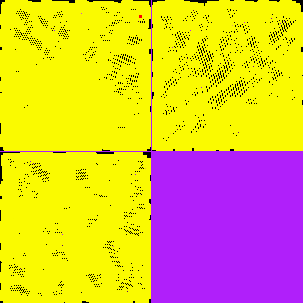

42766

In [41]:
# Create a single segment, starting from the specified origin point.
canvas.segment_at((75, 75, 75),  # zyx
                  dynamic_image=inference.DynamicImage(),
                  vis_update_every=1)

In [32]:
from ffn.utils import bounding_box_pb2
from ffn.inference import inference
from ffn.inference import inference_flags

In [33]:
bbox = bounding_box_pb2.BoundingBox()
bounding_box = 'start { x:0 y:0 z:0 } size { x:151 y:151 z:151 }'
text_format.Parse(bounding_box, bbox)

start {
  x: 0
  y: 0
  z: 0
}
size {
  x: 151
  y: 151
  z: 151
}

In [34]:
runner.run((bbox.start.z, bbox.start.y, bbox.start.x),
             (bbox.size.z, bbox.size.y, bbox.size.x))

In [35]:
from ffn.inference import storage

seg, _ = storage.load_segmentation('brainlit/results', (0, 0, 0))

In [36]:
napari_viewer(img, labels=seg)

In [37]:
from tensorflow import gfile

# filename = "brainlit/seg-0_0_0.cpoint"
filename = "brainlit/results/0/0/seg-0_0_0.npz"

with gfile.Open(filename, 'rb') as f:
      data = np.load(f, allow_pickle=True)